In [1]:
import quandl
import numpy as np
import pandas as pd
import talib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from statistics import mean, stdev
from sklearn.preprocessing import scale 




In [2]:
SOXL = pd.read_csv('/Users/josephseverino/Downloads/SOXL.csv') #ETF growth cycle
Nasdaq = pd.read_csv('/Users/josephseverino/Downloads/Nasdaq.csv') #Index
TQQQ = pd.read_csv('/Users/josephseverino/Downloads/TQQQ.csv') #3X Index
MU = pd.read_csv('/Users/josephseverino/Downloads/MU.csv') #high Beta
AMD = pd.read_csv('/Users/josephseverino/Downloads/AMD.csv') # high beta
NFLX = pd.read_csv('/Users/josephseverino/Downloads/NFLX.csv') #High growth
AMZN = pd.read_csv('/Users/josephseverino/Downloads/AMZN.csv') #High growth
V = pd.read_csv('/Users/josephseverino/Downloads/V.csv') #low volalitity
YINN = pd.read_csv('/Users/josephseverino/Downloads/YINN.csv') #looks like bell curve
NVDA = pd.read_csv('/Users/josephseverino/Downloads/NVDA.csv') #high growth
WTW = pd.read_csv('/Users/josephseverino/Downloads/WTW.csv') #high beta
F = pd.read_csv('/Users/josephseverino/Downloads/F.csv') #highly traded
MSFT = pd.read_csv('/Users/josephseverino/Downloads/MSFT.csv') #high traded
HNGR = pd.read_csv('/Users/josephseverino/Downloads/HNGR.csv') #high beta cyclic
VIX = pd.read_csv('/Users/josephseverino/Downloads/VIX.csv') #high beta cyclic





stocks = [SOXL, Nasdaq, TQQQ, MU, AMD, NFLX, AMZN, V, YINN, NVDA, WTW, F, MSFT, HNGR]

In [3]:
print('SOXL: ',SOXL.shape,
      'Nasdaq: ', Nasdaq.shape,
      'TQQQ: ',TQQQ.shape,
      'MU: ',MU.shape,
      'Visa: ', V.shape,
      'Amazon: ',AMZN.shape,
      'Netflix: ',NFLX.shape,
      'AMD: ',AMD.shape,
      'YINN: ',YINN.shape,
      'NVDA: ', NVDA.shape,
      'WTW: ', WTW.shape,
      'F: ', F.shape,
      'MSFT: ', MSFT.shape,
      'HNGR: ', HNGR.shape,
      'VIX: ', VIX.shape)

SOXL:  (2149, 7) Nasdaq:  (12014, 7) TQQQ:  (2168, 7) MU:  (8649, 7) Visa:  (2647, 7) Amazon:  (5374, 7) Netflix:  (4112, 7) AMD:  (9714, 7) YINN:  (2215, 7) NVDA:  (4949, 7) WTW:  (4241, 7) F:  (11680, 7) MSFT:  (8200, 7) HNGR:  (8214, 7) VIX:  (7238, 7)


# Below is my Feature Engineering

In [4]:
adj_return = lambda x: x + 1
for df in stocks:
    #previous day percentage return
    df['Day_previous_roi'] = df['Open'].pct_change(1)
    
    
    #adding a 1 to return for easier calculations
    df['Day_previous_roi'] = df['Day_previous_roi'].apply(adj_return) 
    
    #current day percentage return
    df['current_roi'] = df['Day_previous_roi'].shift(-1)
    

In [5]:
for df in stocks:
    for n in [10,20,60,200]:
        # Create the moving average indicator and divide by Adj_Close
        df['ma' + str(n)] = talib.SMA(df['Adj Close'].values,timeperiod=n) / df['Adj Close']
        
        #PCT of MA
        df['ma_chg' + str(n)] = df['ma' + str(n)].pct_change()
        
        # Create the RSI indicator
        df['rsi' + str(n)] = talib.RSI(df['Adj Close'].values, timeperiod=n)
        
        #CHG of rsi
        # Create the RSI indicator
        df['rsi_chg' + str(n)] = df['rsi' + str(n)].pct_change()
        
        # time series predictor
        df['tsf' + str(n)] = talib.TSF(df['Adj Close'].values, timeperiod=n)
        
        # Normalize tsf to price
        df['tsf' + str(n)] = df['tsf' + str(n)].values/df['Adj Close'].values

In [6]:
for df in stocks:
     
    #MACD signals
    df['macd'], df['macdsignal'], df['macdhist'] = talib.MACD(df['Close'].values,
                                     fastperiod=12,
                                     slowperiod=26,
                                     signalperiod=9)
        #AROON signals
    df['aroondown'], df['aroonup'] = talib.AROON(df['High'].values,
                                                 df['Low'].values, 
                                                 timeperiod=14)
    
        #OBV
    volume_data = np.array(df['Volume'].values, dtype='f8')
    df['obv'] = talib.OBV(df['Close'].values,
                                         volume_data)
    #candle stick pattern
    df['shawman'] = talib.CDLRICKSHAWMAN(df['Open'].values, df['High'].values, 
                                   df['Low'].values, df['Close'].values)
     #candle stick pattern
    df['hammer'] = talib.CDLHAMMER(df['Open'].values, df['High'].values, 
                                   df['Low'].values, df['Close'].values)
    #cyclical indicator
    df['sine'], df['leadsine'] = talib.HT_SINE(df['Close'].values)
   

In [7]:
#normalizing features 
for df in stocks:
     
    df['macd_diff'] =  df['macd'] - df['macdsignal']
    
    df['macd_diff_hist'] = df['macd'] - df['macdhist']
    
    df['aroon_diff'] =  df['aroonup'] - df['aroondown']
    
    df['obv'] = df['obv'].pct_change(1)
    
   

In [8]:
#looking at the percent difference between the high, low and open close of a 
#day
def dt(start,diff):
    diff = (diff-start)/start
    return diff

for df in stocks:
    df['open_H_ratio'] = dt(df['Open'].values,df['High'].values)
    df['open_L_ratio'] = dt(df['Open'].values,df['Low'].values)
    df['close_H_ratio'] = dt(df['Close'].values,df['High'].values)
    df['close_L_ratio'] = dt(df['Close'].values,df['Low'].values)
        

In [9]:
# trend line slope

for df in stocks:
    for n in [3,5,10,60]:
        #print(n)
        slope = []
        r_sqr = []
        for i in range(len(df['Open'])):
            if i > n:
                X = (np.array(range(n))).reshape(-1,1)
                y = df['Open'][(i-n):i]
                lm = linear_model.LinearRegression()
                model = lm.fit(X,y)
                
                slope.append(model.coef_[0]) 
                r_sqr.append(model.score(X,y))
            else:
                slope.append(np.nan)
                r_sqr.append(np.nan)
            if i == (len(df['Open'])-1):
                df['slope' + str(n)] = slope
                df['r_sqr_' + str(n)] = r_sqr



In [10]:
#20 day moving distribution to see if ROI goes outside of standard deviation
n = 20
for df in stocks:
    std_dev = []
    for i in range(len(df['Open'])):
        if i > n:
            sample = df['current_roi'][i]
            pop_mean = mean(df['current_roi'][(i-n):i])
            pop_std = stdev(df['current_roi'][(i-n):i])
            if sample > ( pop_mean +5*pop_std ): #5 deviation above
                std_dev.append(5)
            elif sample > ( pop_mean +4*pop_std ): #4 deviation above
                std_dev.append(4)
            elif sample > ( pop_mean +3*pop_std ): #3 deviation above
                std_dev.append(3)
            elif sample > ( pop_mean +2*pop_std ): #2 deviation above
                std_dev.append(2)
            elif sample > ( pop_mean + pop_std ): #1 deviation above
                std_dev.append(1)
            elif sample > ( pop_mean - pop_std ): #within 1 deviation 
                std_dev.append(0)
            elif sample > ( pop_mean - 2* pop_std ): #1 deviation below
                std_dev.append(-1)
            elif sample > ( pop_mean - 3* pop_std ): #2 deviation below
                std_dev.append(-2)
            elif sample > ( pop_mean - 4* pop_std ): #3 deviation below
                std_dev.append(-3)
            elif sample > ( pop_mean - 5* pop_std ): #4 deviation below
                std_dev.append(-4)
            else: #5 deviation below
                std_dev.append(-5)
        else:
            std_dev.append(np.nan)
        if i == (len(df['Open'])-1):
            df['stDev' + str(n)] = std_dev
    


In [11]:
#below 10 or more 
#I plan on using this category to train my models
end = Nasdaq.shape[0]
max_price = Nasdaq['Open'][0]
down_array = []
for n in range(end):
    if Nasdaq['Close'][n] > max_price:
        
        #setting the all-time highest price
        max_price = Nasdaq['Close'][n]
    
    #setting percent down form highest price
    down_from_top_percent = 1 + ((Nasdaq['Close'][n] - max_price)/max_price)
    #print(down)
    if down_from_top_percent < .8:
        #bear market
        down_array.append('#ff543a') 
    elif down_from_top_percent < .9:
        #correction
        down_array.append('#eeff32') 
    else:
        #bull market
        down_array.append('#71f442') 
        
        
Nasdaq['down_market'] = down_array   

In [12]:
#recursion from the peak 
for df in stocks:
    end = df.shape[0]
    max_price = df['Open'][0]
    down_array = []
    
    for n in range(end):
        
        if df['Close'][n] > max_price:
            
            #setting the all-time highest price
            max_price = df['Close'][n]
    
        #setting percent down form highest price
        down_from_top_percent = 1 + ((df['Close'][n] - max_price)/max_price)
        #print(down)
        down_array.append(down_from_top_percent)
    df['percent_down'] = down_array  
    

In [13]:
#dummy variable 1 if it's all time high and 0 if not
for df in stocks:
    end = df.shape[0]
    max_price = df['Open'][0]
    max_array = []
    
    for n in range(end):
        if n % 60 == 0:
            max_price = df['Open'][n]
        if df['Open'][n] > max_price:
            max_array.append(1)
            #setting the all-time highest price
            max_price = df['Open'][n]
            
        else:
            max_array.append(0)
    df['semi_pk_pr'] = max_array  
    



In [14]:
#consecutive days up or day
#this will likely only be used for EDA later on
for df in stocks:
    end = df.shape[0]
    counter = 0
    counter_array = []
    for n in range(end):
        if n > 1: #here we reset counter if not consistent
            if counter > 1 and df['Day_previous_roi'][n] <= 1:
                counter = 0
            elif counter < 1 and df['Day_previous_roi'][n] >= 1:
                counter = 0
            elif counter == 1 and df['Day_previous_roi'][n] != 1:
                counter
        if df['Day_previous_roi'][n] > 1:
            counter += 1
        elif df['Day_previous_roi'][n] == 1:
            counter = 0
        else:
            counter -= 1
        counter_array.append(counter)
        
    df['up_dwn_prev'] = counter_array  


In [15]:
#consecutive days up or day
#this will likely only be used for EDA later on
for df in stocks:
    end = df.shape[0]
    counter = 0
    counter_array = []
    for n in range(end):
        if n > 1: #here we reset counter if not consistent
            if counter > 1 and df['current_roi'][n] <= 1:
                counter = 0
            elif counter < 1 and df['current_roi'][n] >= 1:
                counter = 0
            elif counter == 1 and df['current_roi'][n] != 1:
                counter
        if df['current_roi'][n] > 1:
            counter += 1
        elif df['current_roi'][n] == 1:
            counter = 0
        else:
            counter -= 1
        counter_array.append(counter)
        
    df['up_dwn_curr'] = counter_array  

# Creating My target Variables

In [16]:
#Lets make a few target regression variables
for df in stocks:
    for i in [1,3,5,10,20]:
        end = df.shape[0]
        target = 0
        target_array = []
        for n in range(end):
            target = df['current_roi'][n:(n+i)].prod()
            target_array.append(target)
        df['target_' + str(i) +'roi'] = target_array

In [17]:
#now lets do some categorical data
for df in stocks:
    for i in [1,3,5,10,20]:
        end = df.shape[0]
        target_array = []
        
        for n in range(end):
            if n >= (end - i):
                target_array.append(np.nan)
            else: #try .max for np arrays
                target = 1 + (max(df['High'][n:(n+i+1)]) - df['Open'][n])/df['Open'][n]
                if target == 1.0:
                    target = df['target_' + str(i) +'roi'][n]
                target_array.append(target)

        df['tar_' + str(i) +'best_roi'] = target_array
       


In [18]:
#now lets do some categorical data
for df in stocks:
    for i in [1,3,5,10,20]:
        end = df.shape[0]
        qtile = (df['tar_' +str(i) + 'best_roi'].quantile([0.25,0.5,0.75])).values
        class_array = []
        q1 = str(round(qtile[0],4))
        q2 = str(round(qtile[1],4))
        q3 = str(round(qtile[2],4))
        for n in range(end):
            if n >= (end - 1):
                class_array.append(np.nan)
            else:
                target  = 1 + (max(max(df['High'][n:(n+i+1)]),df['Open'][n+1]) - df['Open'][n])/df['Open'][n]
                if target > qtile[2]:
                    class_array.append('abv_' + q3)
                elif target > qtile[1]:
                    class_array.append('abv_' + q2)
                elif target > qtile[0]:
                    class_array.append('abv_' + q1)
                elif target <= qtile[0]:
                    class_array.append('bel_'+ q1)
                    
        df['tar_' + str(i) +'best_class'] = class_array



In [19]:
(V['tar_1best_roi'].quantile([0.25,0.5,0.75])).values

array([1.00554123, 1.01146933, 1.0205347 ])

In [20]:
from collections import Counter
Counter(V['tar_1best_class'])

Counter({'abv_1.0055': 661,
         'abv_1.0115': 661,
         'abv_1.0205': 662,
         'bel_1.0055': 662,
         nan: 1})

In [21]:
for df in stocks:
    end = df.shape[0]
    t_array = []
    for row in df.current_roi:
        
        if row > 1:
            t_array.append('buy')
        else:
            t_array.append('sell')
    df['easy_buy'] = t_array

In [22]:
for df in stocks:
    #print(qtile[1])
    for i in [1,3,5,10,20]:
        qtile = (df['tar_' +str(i) + 'best_roi'].quantile([0.25,0.5,0.75])).values
    
        end = df.shape[0]
        target = 0
        label = ''
        target_array = []
        #print(i)
        for n in range(end):
            if n >= (end - i):
                target_array.append(np.nan)
            else: #try .max for np arrays
                target = 1 + (max(df['High'][n:(n+i+1)]) - df['Open'][n])/df['Open'][n]
            
                if target <= 1.0:
                    
                    target = 1 + ((df['Close'][n+i] - df['Open'][n])/df['Open'][n])
                    #print(n,t)
                    
                if target > qtile[1]:
                    label = 'above_'+ str(qtile[1])
                else:
                    label = 'below_'+ str(qtile[1])
                
                target_array.append(label)
            
        df['tar_' + str(i) +'new_high'] = target_array




In [23]:
for df in stocks:
    for i in [1,3,5,10,20]:
        df['tar_' + str(i) +'new_high'] = df['tar_' + str(i) +'new_high'].shift(-1)
        df['tar_' + str(i) +'best_class'] = df['tar_' + str(i) +'best_class'].shift(-1)
        df['tar_' + str(i) +'best_roi'] = df['tar_' + str(i) +'best_roi'].shift(-1)
        df['target_' + str(i) +'roi'] = df['target_' + str(i) +'roi'].shift(-1)
        

In [24]:
for df in stocks:
    df['easy_buy'] = df['easy_buy'].shift(-1)

# Saving My dataframes as CSVs to use in Analysis

In [25]:
#Drop all NaN values form dataframes

for df in stocks:
    df.replace(-np.inf, np.nan,inplace=True)
    df.replace(np.inf, np.nan,inplace=True)
    df.dropna(inplace=True)
    df.reset_index(inplace=True)


In [26]:

SOXL.name = 'soxl'
Nasdaq.name = 'nasdaq'
TQQQ.name = 'tqqq'   
MU.name = 'mu'
AMD.name = 'amd'
NFLX.name = 'nflx'
AMZN.name = 'amzn'
V.name =  'visa'
YINN.name = 'yinn'
NVDA.name = 'nvda'
WTW.name = 'wtw'
F.name = 'f'
MSFT.name = 'mfst'
HNGR.name = 'hngr'


    

In [27]:
import glob

for df in stocks:
    
    
    # Give the filename you wish to save the file to
    filename = df.name + '_new.csv'

    # Use this function to search for any files which match your filename
    files_present = glob.glob(filename)


    # if no matching files, write to csv, if there are matching files, print statement
    if not files_present:
        df.to_csv(filename)
    else:
        print('WARNING: This file already exists!' )


# Feature Importance Testing 

In [28]:
#MU_cln.columns.values.tolist()
features = ['Day_previous_roi','ma10','rsi10','ma20','rsi20','ma_chg20',
            'ma60','rsi60','ma200','rsi200','obv','macd_diff','ma_chg10',
            'macd_diff_hist','aroon_diff','slope60','r_sqr_60','ma_chg60',
            'slope10','r_sqr_10','slope5','slope3','r_sqr_5','stDev20','ma_chg200',
            'rsi_chg10','rsi_chg20','rsi_chg60','rsi_chg200',
            'percent_down','sine','leadsine','tsf10','tsf20','tsf60','tsf200',
            'up_dwn_prev','shawman','hammer','semi_pk_pr','open_H_ratio',
            'open_L_ratio','close_H_ratio','close_L_ratio']
feature_best = ['Day_previous_roi','ma10','rsi10','ma20','rsi20',
            'ma60','rsi60','ma200','rsi200','obv','macd_diff',
            'macd_diff_hist','aroon_diff','slope60','r_sqr_60',
            'slope10','r_sqr_10','slope5','r_sqr_5',
            'percent_down','sine','leadsine','tsf10',
            'tsf20','tsf60','tsf200',
            'up_dwn_prev','open_H_ratio',
            'open_L_ratio','close_H_ratio','close_L_ratio']
corr_ft = ['Day_previous_roi','ma10','rsi10','ma20','rsi20',
            'ma60','rsi60','ma200','rsi200','obv','macd_diff',
            'macd_diff_hist','aroon_diff','slope60','r_sqr_60',
            'slope10','r_sqr_10','slope5','r_sqr_5','stDev20',
            'percent_down','sine','leadsine','tsf10','tsf20','tsf60','tsf200',
            'up_dwn_prev','shawman','hammer','semi_pk_pr','current_roi']

targets_cat = ['up_dwn_curr',
               'tar_3best_roi',
               'tar_5best_roi',
               'tar_10best_roi',
               'tar_20best_roi',
               'tar_1best_roi',
               'tar_1best_class',
               'tar_3best_class',
               'tar_5best_class',
               'tar_10best_class',
               'tar_20best_class',
               'easy_buy',
               'tar_3new_high',
               'tar_5new_high',
               'tar_10new_high',
               'tar_20new_high']

targets_reg = ['target_3roi',
               'target_5roi',
               'target_10roi',
               'target_20roi']
#Set stock or dataframe
df_cln = NFLX
target_name = 'tar_3best_class'
#.75 make a 25/75 split
stop = round(.9*len(df_cln))

#set features

feature_train = df_cln.loc[:stop,features]
feature_test = df_cln.loc[stop:,features]
    
#set my targets

target_train = df_cln.loc[:stop,[target_name]]
target_test = df_cln.loc[stop:,[target_name]]
    
    

In [29]:
#MU.columns.values.tolist()

In [30]:
print(target_train.shape,target_test.shape,feature_train.shape,feature_test.shape)

(3502, 1) (389, 1) (3502, 44) (389, 44)


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

# Create a random forest classifier
rf2 = RandomForestClassifier(n_estimators=1100,
                            max_features=6,
                            max_depth=11,
                            n_jobs=-1,
                            random_state=42)

# Train the classifier
rf2.fit(feature_train, target_train)


feature_imp = pd.Series(rf2.feature_importances_,index=features).sort_values(ascending=False)
feature_imp
#rf.feature_importances_

//anaconda/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


ma200               0.035422
tsf200              0.032538
macd_diff_hist      0.032475
r_sqr_60            0.031393
slope60             0.029828
percent_down        0.029085
slope10             0.028995
tsf60               0.028367
macd_diff           0.027848
r_sqr_10            0.027726
leadsine            0.026976
slope5              0.026909
rsi200              0.026820
r_sqr_5             0.026651
rsi60               0.026437
obv                 0.026308
ma60                0.026068
tsf20               0.025906
rsi20               0.025902
slope3              0.025843
tsf10               0.025393
sine                0.025321
rsi10               0.024934
close_H_ratio       0.024745
close_L_ratio       0.024378
ma10                0.024356
Day_previous_roi    0.024287
open_L_ratio        0.024234
open_H_ratio        0.024227
ma20                0.024050
aroon_diff          0.021835
ma_chg10            0.018812
ma_chg20            0.018653
ma_chg60            0.018253
rsi_chg10     

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


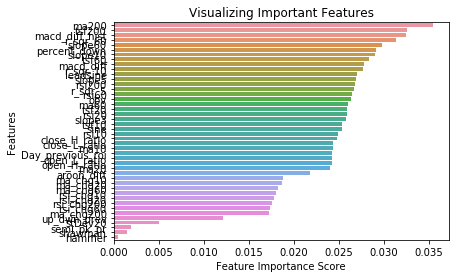

In [32]:
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [33]:
# prediction on test set
target_pred=rf2.predict(feature_test)


#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Cohen Kappa:",metrics.cohen_kappa_score(target_test, target_pred),'\n'
     "Accuracy:",metrics.accuracy_score(target_test, target_pred))

Cohen Kappa: 0.06487654381064534 
Accuracy: 0.36503856041131105


In [34]:

df_cln[target_name].value_counts()

abv_1.0151    992
abv_1.035     989
bel_1.0151    984
abv_1.0686    925
Name: tar_3best_class, dtype: int64

In [35]:
from collections import Counter
Counter(target_test[target_name])

Counter({'abv_1.0151': 128,
         'abv_1.035': 76,
         'abv_1.0686': 50,
         'bel_1.0151': 135})

//anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


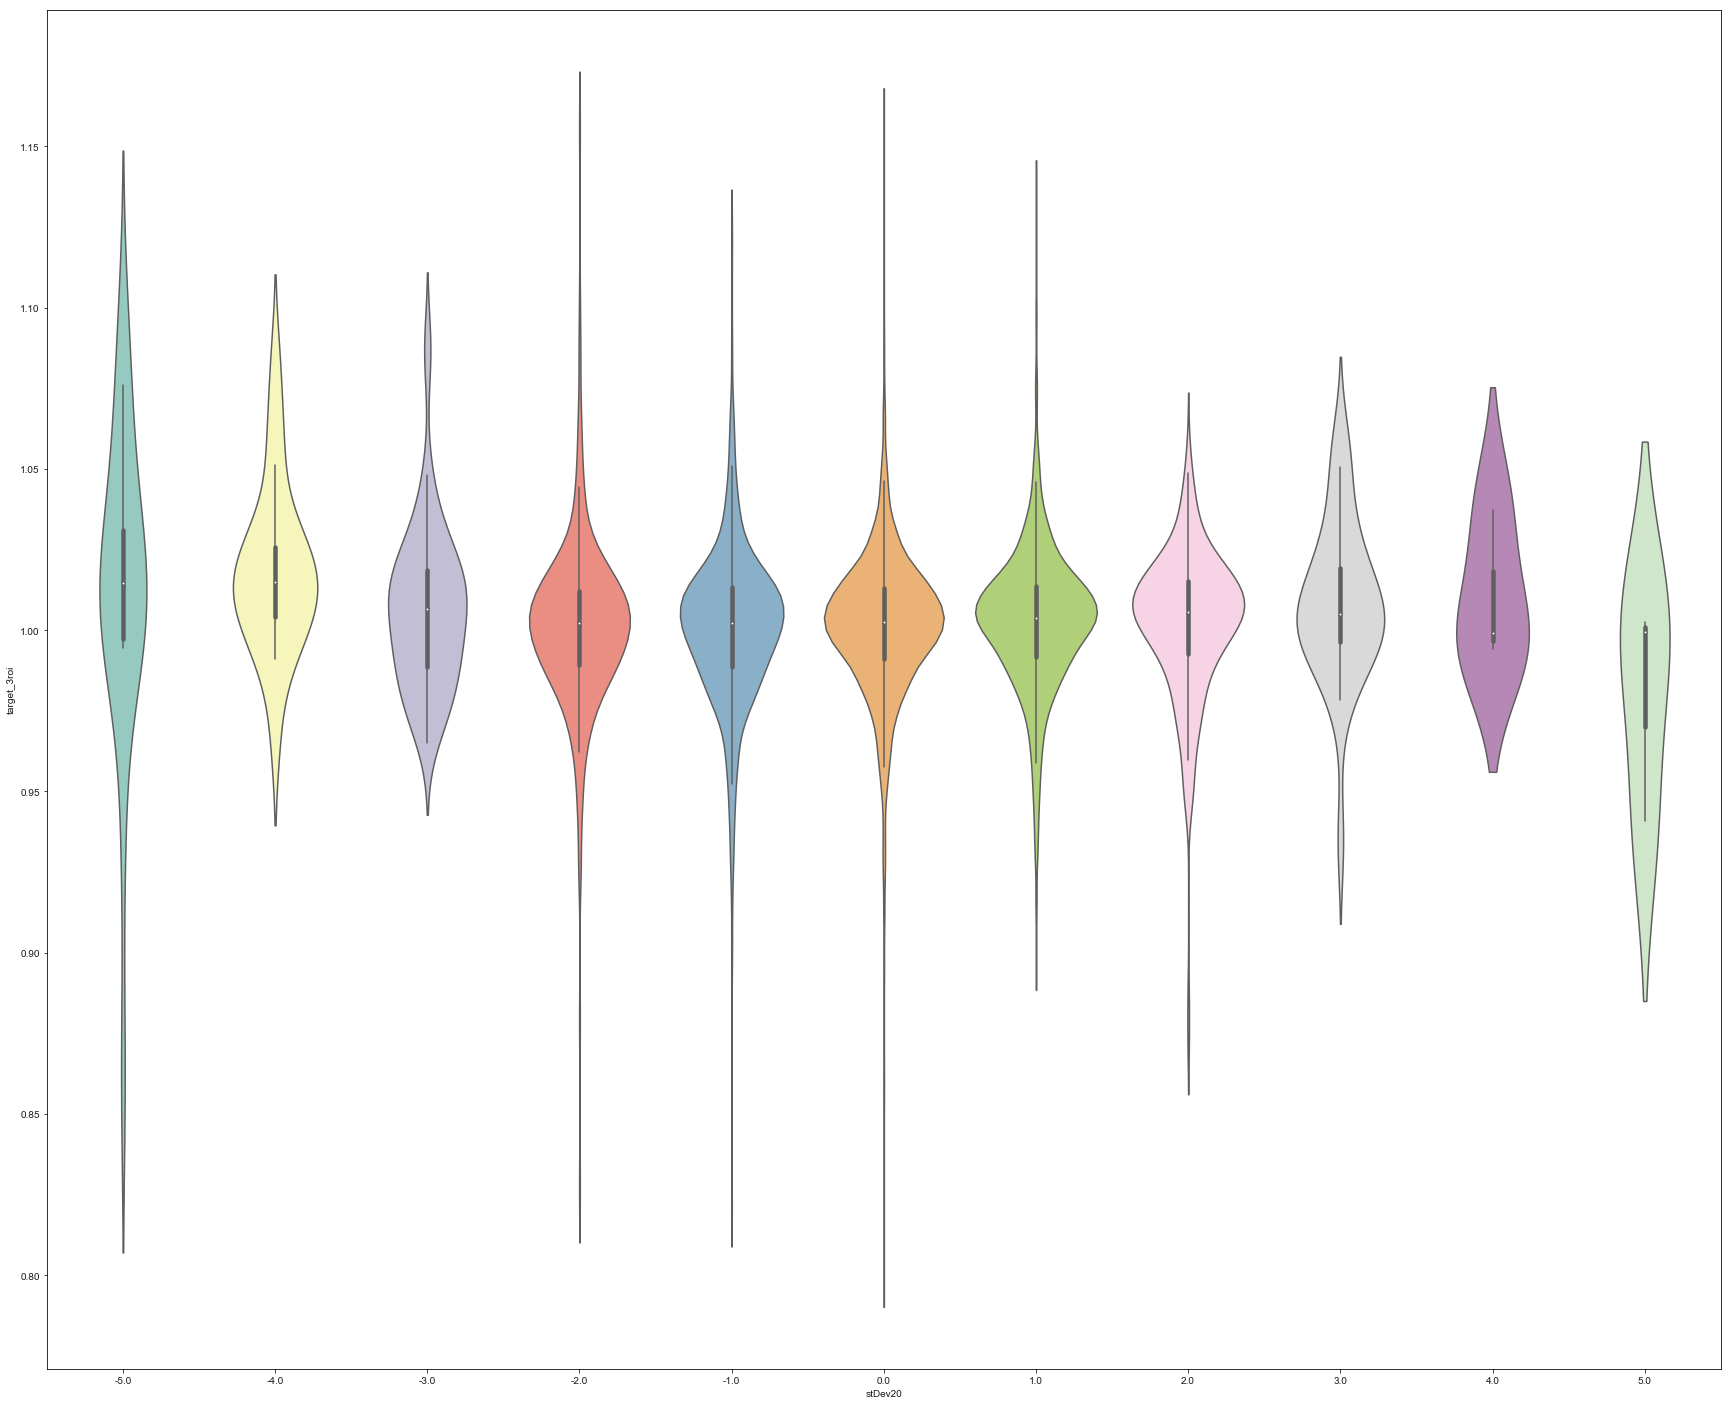

In [36]:
plt.subplots(figsize=(30,25))
sns.set(style="whitegrid")
ax = sns.violinplot(x="stDev20", y="target_3roi", data=Nasdaq,palette="Set3")
